In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import time

from catboost import CatBoostClassifier
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder, RobustScaler)
from sklearn.svm import LinearSVC
from sqlalchemy import create_engine, text
from ydata_profiling import ProfileReport

## Подключение к базе данных и загрузка таблиц sql

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string)
del db_config
del connection_string

## Проведение первичного исследования таблиц

In [4]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   
5  4083097                 0109         alameda       0.0      None   
6  4083092                 1942     los angeles    1320.0     south   
7  4083096                 1942     los angeles     200.0     south   
8  4083100                 1942     los angeles    2112.0     north   
9  4083103                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   
5             1     clear          ramp     small damage            2   
6             0     clear       highway          scratch            2   
7             0     clear       highway          scratch            3   
8             0    cloudy       highway          scratch            2   
9             1    cloudy          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         sideswipe   
1   vehicle code violation         improper passing        hit object   
2   vehicle code violation         improper turning         broadside   
3   vehicle code violation  automobile right of way         broadside   
4   vehicle code violation                 speeding          rear end   
5   vehicle code violation                 speeding          rear end   
6   vehicle code violation       unsafe lane change          rear end   
7   vehicle code violation                 speeding          rear end   
8   vehicle code violation                 speeding          rear end   
9   vehicle code violation                     None         broadside   

  motor_vehicle_involved_with road_surface road_condition_1  \
0         other motor vehicle          wet           normal   
1                fixed object          dry           normal   
2         other motor vehicle          dry           normal   
3         other motor vehicle          dry           normal   
4         other motor vehicle          dry             None   
5         other motor vehicle          dry           normal   
6         other motor vehicle          dry           normal   
7         other motor vehicle          dry           normal   
8         other motor vehicle          dry           normal   
9         other motor vehicle          wet           normal   

                  lighting control_device collision_date collision_time  
0                 daylight           none     2009-01-22       07:25:00  
1  dark with street lights    functioning     2009-01-03       02:26:00  
2  dark with street lights    functioning     2009-01-11       03:32:00  
3                 daylight    functioning     2009-01-11       10:35:00  
4  dark with street lights    functioning     2009-01-02       22:43:00  
5  dark with street lights    functioning     2009-01-18       02:18:00  
6                 daylight           none     2009-01-21       10:30:00  
7                 daylight           none     2009-01-21       08:55:00  
8                 daylight           none     2009-01-21       16:20:00  
9             dusk or dawn    functioning     2009-01-02       15:55:00

In [5]:
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

case_id db_year
0  0081715    2021
1  0726202    2021
2  3858022    2021
3  3899441    2021
4  3899442    2021
5  3899445    2021
6  3899446    2021
7  3899449    2021
8  3899450    2021
9  3899453    2021

In [6]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   
5  1175737  5305046             2        sedan                 auto   
6  1175750  5305053             3        sedan                 auto   
7  1175715  5305033             1        sedan               manual   
8  1175716  5305033             2        sedan               manual   
9  1175758  5305060             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5  
5            5  
6            9  
7           10  
8            4  
9           11

In [7]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   
5  43  3899481             2  road bumper         0                NaN   
6  72  3899505             2  road bumper         0                NaN   
7  73  3899505             3  road bumper         0                NaN   
8  76  3899509             1  road bumper         0                NaN   
9  93  3981292             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None               0.0  
1  had not been drinking                None               0.0  
2  had not been drinking                None               0.0  
3  had not been drinking                None               0.0  
4         not applicable      not applicable               0.0  
5         not applicable      not applicable               0.0  
6         not applicable      not applicable               0.0  
7         not applicable      not applicable               0.0  
8  had not been drinking                None               0.0  
9  had not been drinking                None               NaN

### Выводы
1. Все таблицы имеют данные для выполнения поставленных задач
2. Таблиц достаточно для выполнения поставленных задач
3. Все таблицы имеют общий ключ для связи между собой

##  Проведение статистического анализа факторов ДТП

In [8]:
query = '''
SELECT extract(month from collision_date) as month, count(*)
FROM collisions
GROUP BY month
ORDER BY month;
'''

collisions_per_month = pd.DataFrame(engine.connect().execute(text(query)))

In [9]:
collisions_per_month

month   count
0      1  132044
1      2  128858
2      3  139581
3      4  130180
4      5  130316
5      6  102594
6      7  102227
7      8  104089
8      9  105159
9     10  112237
10    11  104770
11    12  107945

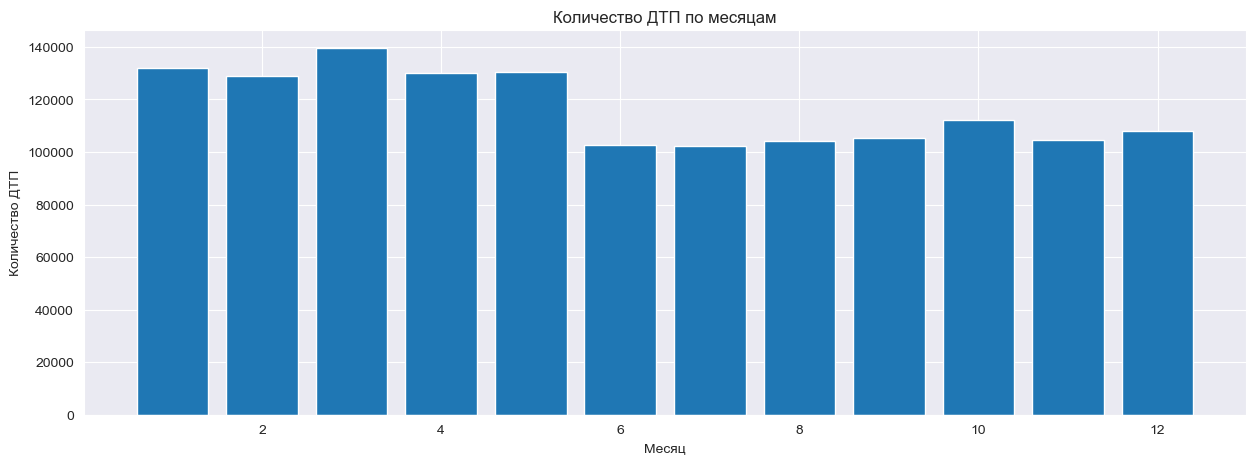

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
plt.bar(collisions_per_month['month'], collisions_per_month['count'])
plt.title('Количество ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.show()

### Количество ДТП по месяцам
* С января по май включительно самое большое количество аварий, примерно в одном диапозоне.
* Март является самым аварийным месяцем.
* С июня по декабрь включительно количество аварий примерно одинаковое и меньше, чем в первой половине года.
* Самое маленькое количество аварий в июле.

### Список задач для статистического анализа
1. Проведите анализ серьёзности повреждений транспортного средства, исходя из тип кузова авто (связать collisions и vehicles)
2. Определите количество ДТП для разных видов коробок передач при разной погоде (связать collisions и vehicles)
3. Определите среднее количество участников ДТП для каждого из типов дорог (связать collisions и parties)
4. Определите, какая степень трезвости участника встречается чаще всего в каждом из районов (связать collisions и parties)
5. Определить зависимость между расстоянием от главной дороги и типом кузова авто (связать collisions и vehicles)

    5.1. Объедините таблицы collisions и vehicles

    5.2. Переведите расстояние в километры, округлите до целого числа

    5.3. Найдите самый популярный тип кузова авто для каждого 5го километра, например: 0-5, 5-10, 10-15 и т.д.

    5.4. Постройте график
    
    5.5. Сделайте вывод
    
6. Определите среднее количество участников ДТП для каждого из типов кузова авто (связать vehicles и parties)

    6.1. Объедините таблицы vehicles и parties

    6.2. Найдите среднее значение участников ДТП

    6.3. Сгрупируйте данные по типу кузова авто

    6.4. Постройте график
    
    6.5. Сделайте вывод

## Создание модели для оценки водительского риска

### Собираем требуемые данные из баззы данных

In [11]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select * from fault)
)

select *
from vehicles
where case_id in (select case_id from final_filter);
'''

vehicles_df = pd.DataFrame(engine.connect().execute(text(query)))

In [12]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select case_id from fault)
)

select *
from collisions
where case_id in (select case_id from final_filter);
'''

collisions_df = pd.DataFrame(engine.connect().execute(text(query)))

In [13]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select * from fault)
)

select *
from parties
where case_id in (select case_id from final_filter);
'''

parties_df = pd.DataFrame(engine.connect().execute(text(query)))

### Подбираем данные для модели

In [14]:
vehicles_df

id  case_id  party_number vehicle_type vehicle_transmission  \
0      1319863  5448303             1        sedan               manual   
1      1463705  5599671             2        sedan                 auto   
2      1463709  5599677             2        sedan                 auto   
3      1463710  5599681             1        sedan                 auto   
4      1463713  5599684             2        sedan                 auto   
...        ...      ...           ...          ...                  ...   
55611  1501364  5638025             1        coupe                 auto   
55612  1501365  5638026             1        coupe                 auto   
55613  1501370  5638028             1        coupe                 auto   
55614  1501373  5638029             2        coupe                 auto   
55615  1501341  5638009             3    hatchback                 auto   

       vehicle_age  
0              2.0  
1              3.0  
2              NaN  
3              0.0  
4              2.0  
...            ...  
55611          7.0  
55612          7.0  
55613          5.0  
55614          5.0  
55615         12.0  

[55616 rows x 6 columns]

In [15]:
vehicles_df = vehicles_df[['case_id', # Требуется для объединения таблиц
                           'party_number', # Требуется для объединения таблиц
                           'vehicle_type', # Тип кузова влияет на характеристики автомобиля тем самым и на возможность аварии, ее последстия и другое
                           'vehicle_transmission', # Тип КПП влияет на воздействие человека на автомобиль тем самым и на возможность аварии
                           'vehicle_age']] # Возраст автомобиля влияет на его техническое состояние, что влияет на возможность аварии

In [16]:
collisions_df

case_id county_city_location county_location  distance direction  \
0       5125192                 4312     santa clara      30.0     south   
1       5403121                 1919     los angeles     111.0      east   
2       5403123                 3900     san joaquin       0.0      None   
3       5403124                 3100          placer    3168.0     north   
4       5403125                 3200          plumas     208.0     north   
...         ...                  ...             ...       ...       ...   
103042  5456995                 4900          sonoma    1056.0     south   
103043  5457256                 3711       san diego       0.0      None   
103044  5457264                 3711       san diego       0.0      None   
103045  5457422                 1915     los angeles     155.0     south   
103046  5457535                 1942     los angeles       0.0      None   

        intersection weather_1 location_type collision_damage  party_count  \
0                0.0    cloudy          None     small damage            2   
1                0.0     clear       highway            fatal            1   
2                1.0     clear          None            fatal            2   
3                0.0     clear       highway            fatal            2   
4                0.0     clear       highway            fatal            1   
...              ...       ...           ...              ...          ...   
103042           0.0     clear          None    middle damage            2   
103043           1.0     clear          None    middle damage            2   
103044           1.0     clear          None    middle damage            2   
103045           0.0       fog          None    middle damage            2   
103046           1.0    cloudy          None    middle damage            2   

       primary_collision_factor      pcf_violation_category type_of_collision  \
0        vehicle code violation  unsafe starting or backing             other   
1        vehicle code violation            improper turning        hit object   
2        vehicle code violation   traffic signals and signs         broadside   
3        vehicle code violation          wrong side of road           head-on   
4        vehicle code violation                    speeding        hit object   
...                         ...                         ...               ...   
103042   vehicle code violation                    speeding             other   
103043   vehicle code violation     pedestrian right of way             other   
103044   vehicle code violation            improper turning             other   
103045   vehicle code violation            improper turning             other   
103046   vehicle code violation     pedestrian right of way             other   

       motor_vehicle_involved_with road_surface road_condition_1  \
0             parked motor vehicle          dry           normal   
1                     other object          dry           normal   
2              other motor vehicle          dry           normal   
3              other motor vehicle          dry           normal   
4                     fixed object          dry           normal   
...                            ...          ...              ...   
103042                other object          dry           normal   
103043                other object          dry           normal   
103044                other object          dry           normal   
103045                other object          dry           normal   
103046                other object          dry           normal   

                          lighting control_device collision_date  \
0                         daylight    functioning     2012-03-16   
1                         daylight           none     2012-01-05   
2                         daylight           none     2012-01-07   
3       dark with no street lights           none     2012-01-09   
4       dark with no street 

In [17]:
collisions_df = collisions_df[['case_id', # Требуется для объединения таблиц
                               'county_city_location', # Разные города имеют разные дороги, что влияет на возможность аварии
                               'distance', # Расстояние от главной дороги может влиять на качество дороги, что влияет на возможность аварии
                               'direction', # Не известно как может направление движения влиять на возможность аварии, стоит проверить
                               'intersection', # Сложный перекресток может влиять на принятие решения человеком
                               'weather_1', # Погода создает определенные условия для вождения
                               'location_type', # Тип дороги влияет на скорость движения и восприятия пути человеком
                               'primary_collision_factor', # Неправильные действия при вождении увеличивают вероятность аварии
                               'pcf_violation_category', # Неправильные действия при вождении увеличивают вероятность аварии
                               'road_surface', # Дорожное покрытие влияет на поведение автомобиля
                               'road_condition_1', # Состояние дороги влияет на поведение автомобиля
                               'lighting', # Освещение влияет на видимость дороги и других автомобилей
                               'collision_date',# Возьмем месяц аварии. Мы узнали, что в первой половине года аварий больше
                               'collision_time']] # Возьмем час аварии для упрощения признака

In [18]:
parties_df

id  case_id  party_number   party_type  at_fault  \
0       2469249  5488558             2  road bumper         0   
1       2473241  5490711             3  road bumper         0   
2       2656298  5599118             3  road bumper         0   
3       2662749  5603028             3  road bumper         0   
4       2469250  5488558             3  road bumper         0   
...         ...      ...           ...          ...       ...   
198476  2405156  5454128             3          car         0   
198477  2405157  5454129             1          car         1   
198478  2405158  5454129             2          car         0   
198479  2405159  5454130             1          car         1   
198480  2405160  5454130             2          car         0   

        insurance_premium                      party_sobriety  \
0                     NaN                                None   
1                     NaN                                None   
2                     NaN                                None   
3                     NaN                                None   
4                     NaN                                None   
...                   ...                                 ...   
198476               59.0               had not been drinking   
198477               44.0  had been drinking, under influence   
198478               32.0               had not been drinking   
198479               35.0               had not been drinking   
198480               48.0               had not been drinking   

       party_drug_physical  cellphone_in_use  
0                     None               NaN  
1                     None               NaN  
2                     None               NaN  
3                     None               NaN  
4                     None               NaN  
...                    ...               ...  
198476                None               0.0  
198477                None               1.0  
198478                None               1.0  
198479                None               0.0  
198480                None               0.0  

[198481 rows x 9 columns]

In [19]:
parties_df = parties_df[['case_id', # Требуется для объединения таблиц
                         'party_number', # Требуется для объединения таблиц
                         'at_fault', # Целевая переменная
                         'insurance_premium', # Стоимость страховки может влиять на качество вождения
                         'party_sobriety', # Состояние водителя влияет на качество вождения
                         'party_drug_physical', # Состояние водителя влияет на качество вождения
                         'cellphone_in_use']]   # Мобильное устройство может отвлекать водителя

### Формируем полную таблицу для модели и проводим анализ

In [20]:
parties_vehicles_df = parties_df.merge(vehicles_df, on=['case_id', 'party_number'], how='left')
df = parties_vehicles_df.merge(collisions_df, on='case_id', how='left')
df.shape

(198481, 23)

In [21]:
df

case_id  party_number  at_fault  insurance_premium  \
0       5488558             2         0                NaN   
1       5490711             3         0                NaN   
2       5599118             3         0                NaN   
3       5603028             3         0                NaN   
4       5488558             3         0                NaN   
...         ...           ...       ...                ...   
198476  5454128             3         0               59.0   
198477  5454129             1         1               44.0   
198478  5454129             2         0               32.0   
198479  5454130             1         1               35.0   
198480  5454130             2         0               48.0   

                            party_sobriety party_drug_physical  \
0                                     None                None   
1                                     None                None   
2                                     None                None   
3                                     None                None   
4                                     None                None   
...                                    ...                 ...   
198476               had not been drinking                None   
198477  had been drinking, under influence                None   
198478               had not been drinking                None   
198479               had not been drinking                None   
198480               had not been drinking                None   

        cellphone_in_use vehicle_type vehicle_transmission  vehicle_age  ...  \
0                    NaN          NaN                  NaN          NaN  ...   
1                    NaN          NaN                  NaN          NaN  ...   
2                    NaN          NaN                  NaN          NaN  ...   
3                    NaN          NaN                  NaN          NaN  ...   
4                    NaN          NaN                  NaN          NaN  ...   
...                  ...          ...                  ...          ...  ...   
198476               0.0        sedan                 auto          7.0  ...   
198477               1.0          NaN                  NaN          NaN  ...   
198478               1.0          NaN                  NaN          NaN  ...   
198479               0.0          NaN                  NaN          NaN  ...   
198480               0.0          NaN                  NaN          NaN  ...   

       intersection  weather_1 location_type  primary_collision_factor  \
0               0.0      clear          None    vehicle code violation   
1               0.0      clear          None    vehicle code violation   
2               0.0      clear          None    vehicle code violation   
3               0.0      clear          None    vehicle code violation   
4               0.0      clear          None    vehicle code violation   
...             ...        ...           ...                       ...   
198476          0.0      clear       highway    vehicle code violation   
198477          0.0      clear       highway    vehicle code violation   
198478          0.0      clear       highway    vehicle code violation   
198479          1.0      clear          ramp    vehicle code violation   
198480          1.0      clear          ramp    vehicle code violation   

           pcf_violation_category road_surface road_condition_1  \
0                        speeding          dry           normal   
1                improper turning          dry           normal   
2                             dui          dry           normal   
3                            None          dry           normal   
4                        speeding          dry           normal   
...                           ...          ...              ...   
198476                   speeding          dry           normal   
198477                        dui          dry           normal   
198478           

### Предобработка признаков

In [22]:
cat_column = []
num_column = []

Данные для создания таблиц

In [23]:
df.drop(['case_id', 'party_number'], axis=1, inplace=True)

at_fault

In [24]:
df['at_fault'] = df['at_fault'].astype('bool')
cat_column.append('at_fault')

insurance_premium

In [25]:
df['insurance_premium'] = df['insurance_premium'].fillna(0)
num_column.append('insurance_premium')

party_sobriety

In [26]:
df['party_sobriety'] = df['party_sobriety'].fillna('had not been drinking')
cat_column.append('party_sobriety')

party_drug_physical

In [27]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('no drugs')
cat_column.append('party_drug_physical')

cellphone_in_use

In [28]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)
df['cellphone_in_use'] = df['cellphone_in_use'].astype('bool')
cat_column.append('cellphone_in_use')

vehicle_type

In [29]:
df['vehicle_type'] = df['vehicle_type'].fillna('not applicable')
cat_column.append('vehicle_type')

vehicle_transmission

In [30]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('not applicable')
cat_column.append('vehicle_transmission')

vehicle_age

In [31]:
df['vehicle_age'] = df['vehicle_age'].fillna(0)
num_column.append('vehicle_age')

county_city_location

In [32]:
num_column.append('county_city_location')

distance

In [33]:
num_column.append('distance')

direction

In [34]:
df['direction'] = df['direction'].fillna('unknown')
cat_column.append('direction')

intersection

In [35]:
df['intersection'] = df['intersection'].fillna(0)
df['intersection'] = df['intersection'].astype('bool')
cat_column.append('intersection')

weather_1

In [36]:
df['weather_1'] = df['weather_1'].fillna('unknown')
cat_column.append('weather_1')

location_type

In [37]:
df['location_type'] = df['location_type'].fillna('road')
cat_column.append('location_type')

primary_collision_factor

In [38]:
cat_column.append('primary_collision_factor')

pcf_violation_category

In [39]:
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')
cat_column.append('pcf_violation_category')

road_surface

In [40]:
df['road_surface'] = df['road_surface'].fillna('dry')
cat_column.append('road_surface')

road_condition_1

In [41]:
df['road_condition_1'] = df['road_condition_1'].fillna('normal')
cat_column.append('road_condition_1')

lighting

In [42]:
df['lighting'] = df['lighting'].fillna('daylight')
cat_column.append('lighting')

collision_date

In [43]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['month'] = df['collision_date'].dt.month
df.drop('collision_date', axis=1, inplace=True)
cat_column.append('month')

collision_time

In [44]:
df['collision_time'] = df['collision_time'].fillna('00')
df['collision_time'] = df['collision_time'].apply(lambda x: str(x)[:2]).astype(int)
df['collision_time'] = df['collision_time'].astype('int')
cat_column.append('collision_time')

In [45]:
len(num_column), len(cat_column)

(4, 17)

### Анализ данных

In [46]:
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

In [47]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
profile.to_file('car_accidents_analysis.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
df.to_csv('df.csv', index=False)

### Выводы по анализу данных
1. at_fault имеет почти равное количество значений 0 и 1, что добавит точности при обучении модели
2. insurance_premium имеет правильное распределение с некоторыми скачками, возможно, это связано с маркетинговой деятельностью и прайс-листом. Все пропуски в данных были заполнены нулями, так как предположительно данные средства были не застрахованы.
3. party_sobriety и party_drug_physical имеют похожие распределения и в 80% данных зафиксированно отсутствие алкогольного, наркатического опьянения и других воздействий. Пропуски в данных заполнили отсутствием воздействий. Корреляция, также, похожа.
4. cellphone_in_use имеет в 99% случаев отрицательное значение.
5. vehicle_type, vehicle_transmission, vehicle_age основная масса данных была не зафиксированна так как не все участники аварии явлаются транспортным средством.
6. county_city_location вифим, что есть некоторые города, в которых аварий сильно больше чем в других.
7. distance четверь данных является пропущенными, что может быть связанно с тем, что авария произошла на основной дороге.
8. direction количество значений примерно похоже, но на дорогах с севера на юг аварий больше. Также, есть не зафиксированные данные, их около 20%.
9. intersection 80% аварий происходит не на перекрестке.
10. weather_1 основная масса аварий происходит в безоблачную погоду. Такая погода является распространенной в Калифорнии.
11. location_type основная масса данных пропущена и была заполнена значением 'road'.
12. primary_collision_factor 99% данных говорат о нарушении правил. Данные имеют очень высокую корреляцию и являются сильно не сбалансированными.
13. pcf_violation_category имеет нормальное распределение с сильным приобладанием нарушения правил скоростного режима.
15. road_surface 95% данных говорят о сухой дороге. Признак имеет высокую корреляцию и является сильно не сбалансированным.
16. road_condition_1 99% говорят о нормальной дороге.
17. lighting имеет нормальное распределение с сильным приобладанием дневного света.
18. collision_time нормальное распределение с двумя вершинами в 7-8 часов и 15-17 часов. Похоже на интервалы поездок на работу.
19. month в нашем наборе данных основная часть информации об аварих в первую половину года.

### Подготовка датасета к обучению модели

In [50]:
try:
    print('df is ready', df.shape)
except:
    df = pd.read_csv('df.csv')
    print('df is downloaded and ready', df.shape)

df is ready (198481, 21)


In [51]:
df.drop_duplicates(inplace=True)

In [52]:
train = df.drop('at_fault', axis=1)
target = df['at_fault'].astype('int')

In [53]:
cat_cols = train.select_dtypes(exclude='number').columns.tolist()
num_cols = train.select_dtypes(include='number').columns.tolist()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

### Создание пайплана и обучение моделей

Задача стоит в разработке системы прогнозирования виновника аварии. Наша основная цель - минимизировать шанс аварии с виновником арендующим транспортное средство компании. Если мы можем предсказать аварию заблаговременно, это поможет нам сократить издержки.

В контексте нашего вопроса, recall может быть наиболее важной метрикой, так как нам важно идентифицировать и предотвратить аварии (истинно положительные случаи), а неправильно ее предсказать не так страшно (ложно положительные случаи).

После проведенных тестов, стало ясно что Recall, дает неподходящий результат из-за переобучения. Будем брать F1 меру.

In [55]:
num_pipeline = Pipeline(steps=[
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    #('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

In [56]:
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', CatBoostClassifier())
])

params = {
    'model__depth': [4, 5, 6, 7, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.075, 0.1, 0.15, 0.2],
    'model__l2_leaf_reg': [1, 2, 3, 4, 5, 7],
    'model__iterations': [100, 150, 200, 250, 300, 500],
    'model__border_count': [5, 10, 20, 30, 40],
    'model__thread_count': [2, 4, 6],
    'model__early_stopping_rounds': [10],
    'model__random_strength': [0.01, 0.1, 1, 1.5, 2],
    'model__max_ctr_complexity': [1, 2, 3, 4, 5]
}

cbc_grid = RandomizedSearchCV(pipeline,
                          params,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=42,
                          scoring='f1',
                          n_jobs=-1)

start = time.time()
cbc_grid.fit(X_train, y_train)
end = time.time()
cbc_time = end - start

print("Best Parameters:", cbc_grid.best_params_)
print("Best F1 Score:", cbc_grid.best_score_)
print("Time:", cbc_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.6903643	total: 76.6ms	remaining: 19.1s
0:	learn: 0.6903749	total: 83.2ms	remaining: 20.7s
1:	learn: 0.6876941	total: 99.9ms	remaining: 12.4s
1:	learn: 0.6876512	total: 105ms	remaining: 13s
2:	learn: 0.6849518	total: 116ms	remaining: 9.55s
2:	learn: 0.6849382	total: 122ms	remaining: 10.1s
3:	learn: 0.6824209	total: 132ms	remaining: 8.15s
3:	learn: 0.6824067	total: 141ms	remaining: 8.66s
4:	learn: 0.6798213	total: 161ms	remaining: 7.91s
4:	learn: 0.6798546	total: 170ms	remaining: 8.31s
5:	learn: 0.6774777	total: 187ms	remaining: 7.62s
5:	learn: 0.6774288	total: 190ms	remaining: 7.74s
6:	learn: 0.6750381	total: 206ms	remaining: 7.16s
6:	learn: 0.6750943	total: 210ms	remaining: 7.29s
7:	learn: 0.6727165	total: 221ms	remaining: 6.68s
7:	learn: 0.6727901	total: 228ms	remaining: 6.9s
8:	learn: 0.6704776	total: 251ms	remaining: 6.71s
8:	learn: 0.6705698	total: 257ms	remaining: 6.89s
9:	learn: 0.6682384	total: 272ms	remai

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


287:	learn: 0.5169654	total: 11.2s	remaining: 465ms
295:	learn: 0.5187371	total: 10.8s	remaining: 146ms
24:	learn: 0.5192153	total: 1.51s	remaining: 16.6s
28:	learn: 0.5609945	total: 1.18s	remaining: 4.91s
192:	learn: 0.5181950	total: 8.69s	remaining: 315ms
24:	learn: 0.5171419	total: 1.99s	remaining: 21.9s
296:	learn: 0.5186683	total: 10.8s	remaining: 109ms
288:	learn: 0.5168657	total: 11.2s	remaining: 426ms
134:	learn: 0.4597076	total: 7.38s	remaining: 9.01s
29:	learn: 0.5587998	total: 1.21s	remaining: 4.83s
193:	learn: 0.5181265	total: 8.71s	remaining: 270ms
289:	learn: 0.5167905	total: 11.2s	remaining: 387ms
297:	learn: 0.5186188	total: 10.9s	remaining: 73ms
194:	learn: 0.5180714	total: 8.74s	remaining: 224ms
25:	learn: 0.5165389	total: 2.04s	remaining: 21.5s
25:	learn: 0.5186166	total: 1.57s	remaining: 16.6s
290:	learn: 0.5167285	total: 11.3s	remaining: 348ms
30:	learn: 0.5581049	total: 1.24s	remaining: 4.78s
135:	learn: 0.4589748	total: 7.42s	remaining: 8.95s
298:	learn: 0.518579

In [57]:
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', LogisticRegression(tol=0.01))
])

param_dist = {
    'model__C': np.logspace(-3, 3, 7),
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

lr_grid = RandomizedSearchCV(pipeline,
                          param_dist,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=42,
                          scoring='f1',
                          n_jobs=-1)

start = time.time()
lr_grid.fit(X_train, y_train)
end = time.time()
lr_time = end - start

print("Best Parameters:", lr_grid.best_params_)
print("Best F1 Score:", lr_grid.best_score_)
print("Time:", lr_time)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


The total space of parameters 28 is smaller than n_iter=50. Running 28 iterations. For exhaustive searches, use GridSearchCV.


[CV 1/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.649 total time=   0.6s
[CV 2/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.656 total time=   0.6s


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV 3/3] END model__C=0.001, model__penalty=l1, model__solver=liblinear;, score=0.662 total time=   0.9s
[CV 2/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.649 total time=   0.7s
[CV 3/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.654 total time=   0.6s
[CV 1/3] END model__C=0.001, model__penalty=l2, model__solver=liblinear;, score=0.646 total time=   0.7s
[CV 1/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.649 total time=   1.1s
[CV 2/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.655 total time=   1.4s
[CV 3/3] END model__C=0.01, model__penalty=l1, model__solver=liblinear;, score=0.656 total time=   1.1s
[CV 1/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.644 total time=   4.6s
[CV 2/3] END model__C=0.001, model__penalty=l1, model__solver=saga;, score=0.650 total time=   4.6s
[CV 3/3] END model__C=0.001, model__penalty=l1, model__solver=saga;,

In [58]:
pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', RandomForestClassifier())
])

param_dist = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

rfc_grid = RandomizedSearchCV(pipeline,
                    param_dist,
                    n_iter=30,
                    cv=5,
                    verbose=5,
                    random_state=42,
                    scoring='f1',
                    n_jobs=-1)

start = time.time()
rfc_grid.fit(X_train, y_train)
end = time.time()
rfc_time = end - start

print("Best Parameters:", rfc_grid.best_params_)
print("Best F1 Score:", rfc_grid.best_score_)
print("Time:", rfc_time)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.


[CV 1/5] END model__max_depth=None, model__n_estimators=100;, score=0.658 total time=  16.6s


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV 2/5] END model__max_depth=None, model__n_estimators=100;, score=0.661 total time=  16.7s
[CV 3/5] END model__max_depth=None, model__n_estimators=100;, score=0.665 total time=  17.0s
[CV 4/5] END model__max_depth=None, model__n_estimators=100;, score=0.657 total time=  17.0s
[CV 5/5] END model__max_depth=None, model__n_estimators=100;, score=0.669 total time=  17.2s
[CV 1/5] END model__max_depth=None, model__n_estimators=200;, score=0.659 total time=  34.0s
[CV 2/5] END model__max_depth=None, model__n_estimators=200;, score=0.659 total time=  33.8s
[CV 3/5] END model__max_depth=None, model__n_estimators=200;, score=0.665 total time=  33.7s
[CV 4/5] END model__max_depth=None, model__n_estimators=200;, score=0.656 total time=  34.1s
[CV 5/5] END model__max_depth=None, model__n_estimators=200;, score=0.673 total time=  34.3s
[CV 2/5] END model__max_depth=None, model__n_estimators=300;, score=0.660 total time=  53.2s
[CV 1/5] END model__max_depth=None, model__n_estimators=300;, score=0.

In [59]:
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', LinearSVC())
])

param_dist = {
    'model__C': np.logspace(-3, 3, 7),
    'model__loss': ['hinge', 'squared_hinge'],
    'model__max_iter': np.arange(100, 1000, 100)
}

svc_grid = RandomizedSearchCV(pipeline,
                          param_dist,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=42,
                          scoring='f1',
                          n_jobs=-1)

start = time.time()
svc_grid.fit(X_train, y_train)
end = time.time()
svc_time = end - start

print("Best Parameters:", svc_grid.best_params_)
print("Best F1 Score:", svc_grid.best_score_)
print("Time:", svc_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/s

[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.691 total time=   5.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.585 total time=   6.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=200;, score=0.681 total time=   6.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.694 total time=   7.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.377 total time=   7.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=200;, score=0.277 total time=   7.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.692 total time=  15.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.699 total time=  14.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=500;, score=0.065 total time=  15.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.114 total time=  14.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.672 total time=  19.0s
[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.691 total time=  26.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=500;, score=0.693 total time=  19.2s
[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.673 total time=  26.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.689 total time=  23.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=900;, score=0.690 total time=  33.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.533 total time=  18.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.570 total time=  15.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.311 total time=  15.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.696 total time=   5.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=600;, score=0.063 total time=  18.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.679 total time=   3.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=100;, score=0.085 total time=   5.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.632 total time=   8.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.633 total time=   8.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=500;, score=0.655 total time=  22.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=hinge, model__max_iter=500;, score=0.631 total time=  12.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.696 total time=  29.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.319 total time=  29.5s
[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.300 total time=   5.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.700 total time=   3.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=100;, score=0.698 total time=   3.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.697 total time=  28.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.697 total time=  28.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=900;, score=0.699 total time=  38.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.690 total time=  19.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.437 total time=  19.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.112 total time=   3.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.558 total time=   3.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=squared_hinge, model__max_iter=600;, score=0.508 total time=  24.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=900;, score=0.691 total time=  37.1s
[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=100;, score=0.695 total time=   3.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.665 total time=   6.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.478 total time=   6.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.646 total time=   8.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=200;, score=0.686 total time=   8.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.656 total time=   6.6s
[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.687 total time=  24.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.691 total time=  24.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.674 total time=  21.8s
[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.687 total time=  21.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=200;, score=0.484 total time=   7.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=700;, score=0.686 total time=  23.6s
[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=800;, score=0.613 total time=  32.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.692 total time=   3.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.078 total time=   9.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.138 total time=   7.0s
[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=200;, score=0.511 total time=   9.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.696 total time=   3.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=100;, score=0.697 total time=   3.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.695 total time=  10.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.694 total time=  10.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=300;, score=0.642 total time=  10.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.431 total time=   3.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.484 total time=   3.5s
[CV 3/3] END model__C=0.001, model__loss=hinge, model__max_iter=100;, score=0.424 total time=   3.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.684 total time=   9.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.694 total time=   9.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.697 total time=  15.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=300;, score=0.675 total time=   9.3s
[CV 3/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.682 total time=  16.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=10.0, model__loss=hinge, model__max_iter=500;, score=0.684 total time=  21.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.622 total time=  24.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.674 total time=  15.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.699 total time=  18.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.683 total time=  34.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=500;, score=0.698 total time=  18.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=900;, score=0.439 total time=  35.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.211 total time=  23.1s
[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.696 total time=  22.1s
[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.694 total time=  15.2s
[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.670 total time=  15.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=600;, score=0.673 total time=  22.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=400;, score=0.654 total time=  18.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/s

[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.691 total time=  11.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.695 total time=   4.0s
[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.085 total time=  11.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.531 total time=   4.1s
[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=300;, score=0.495 total time=  11.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/s

[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=100;, score=0.304 total time=   5.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.671 total time=   8.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.113 total time=  10.1s
[CV 2/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.698 total time=   9.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=squared_hinge, model__max_iter=300;, score=0.479 total time=   9.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.390 total time=   6.6s
[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.591 total time=  20.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=200;, score=0.689 total time=   8.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.401 total time=  19.7s
[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=700;, score=0.649 total time=  20.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5

[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.234 total time=  26.3s
[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.167 total time=  26.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=800;, score=0.684 total time=  33.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.166 total time=  21.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.190 total time=  21.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=squared_hinge, model__max_iter=700;, score=0.699 total time=  22.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.655 total time=  22.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.637 total time=  22.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.684 total time=  18.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.050 total time=  22.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.308 total time=  22.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=700;, score=0.689 total time=  22.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=700;, score=0.657 total time=  28.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.655 total time=  15.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=500;, score=0.371 total time=  15.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.280 total time=  12.6s
[CV 1/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.148 total time=  22.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 2/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.433 total time=  22.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.1, model__loss=hinge, model__max_iter=700;, score=0.697 total time=  22.3s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.547 total time=  25.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.427 total time=  28.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.096 total time=  28.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.241 total time=  10.0s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.685 total time=  25.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.681 total time=   9.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.660 total time=  13.1s
[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=400;, score=0.697 total time=  12.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Lib

[CV 1/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.622 total time=   3.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=hinge, model__max_iter=900;, score=0.435 total time=  36.2s
[CV 2/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.649 total time=   3.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=800;, score=0.693 total time=  31.6s
[CV 3/3] END model__C=0.001, model__loss=squared_hinge, model__max_iter=100;, score=0.389 total time=   3.8s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=300;, score=0.263 total time=  10.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.307 total time=   6.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.035 total time=   6.6s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=1.0, model__loss=squared_hinge, model__max_iter=200;, score=0.702 total time=   8.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.484 total time=  19.6s
[CV 2/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.121 total time=  19.4s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV 3/3] END model__C=100.0, model__loss=hinge, model__max_iter=600;, score=0.693 total time=  19.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.688 total time=  22.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.244 total time=   6.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.698 total time=  22.2s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.658 total time=  21.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.528 total time=   6.1s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=700;, score=0.435 total time=  26.5s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END model__C=0.01, model__loss=squared_hinge, model__max_iter=200;, score=0.696 total time=   5.9s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.691 total time=  20.9s
[CV 3/3] END model__C=0.01, model__loss=hinge, model__max_iter=800;, score=0.692 total time=  20.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.091 total time=  17.1s
[CV 3/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.686 total time=  16.7s


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END model__C=1000.0, model__loss=hinge, model__max_iter=600;, score=0.617 total time=  20.1s


The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.


Best Parameters: {'model__max_iter': 100, 'model__loss': 'squared_hinge', 'model__C': 0.1}
Best F1 Score: 0.6950772437396111
Time: 252.9077229499817


Liblinear failed to converge, increase the number of iterations.


In [60]:
pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', DummyClassifier(strategy='most_frequent'))
])

params = {}

dc_grid = RandomizedSearchCV(pipeline, params)

start = time.time()
dc_grid.fit(X_train, y_train)
end = time.time()
dc_time = end - start

print("Best Parameters:", dc_grid.best_params_)
print("Best F1 Score:", dc_grid.best_score_)
print("Time:", dc_time)

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best Parameters: {}
Best F1 Score: 0.5270955515624982
Time: 2.6308093070983887


In [61]:
results = {'Model:': ['CatBoostClassifier', 
                      'LogisticRegression', 
                      'RandomForestClassifier',
                      'SVC',
                      'DummyClassifier'],
           'Best F1:': [cbc_grid.best_score_, 
                                lr_grid.best_score_, 
                                rfc_grid.best_score_,
                                svc_grid.best_score_,
                                dc_grid.best_score_],
            'Time (sec/fit):': [cbc_time/150, lr_time/84, rfc_time/125, svc_time/150, dc_time]}
results = pd.DataFrame(results)
results

Model:  Best F1:  Time (sec/fit):
0      CatBoostClassifier  0.707263         1.138427
1      LogisticRegression  0.655648         0.416811
2  RandomForestClassifier  0.697552         3.791350
3                     SVC  0.695077         1.686051
4         DummyClassifier  0.527096         2.630809

### Вывод

В конечном итоге была выбрана F1 мера.

CBC модель показала себя лучше в предсказании и одной из лучших в скорости обучения. Возьмем ее для дальнейшего тестирования.

## Проведение анализ важности факторов ДТП

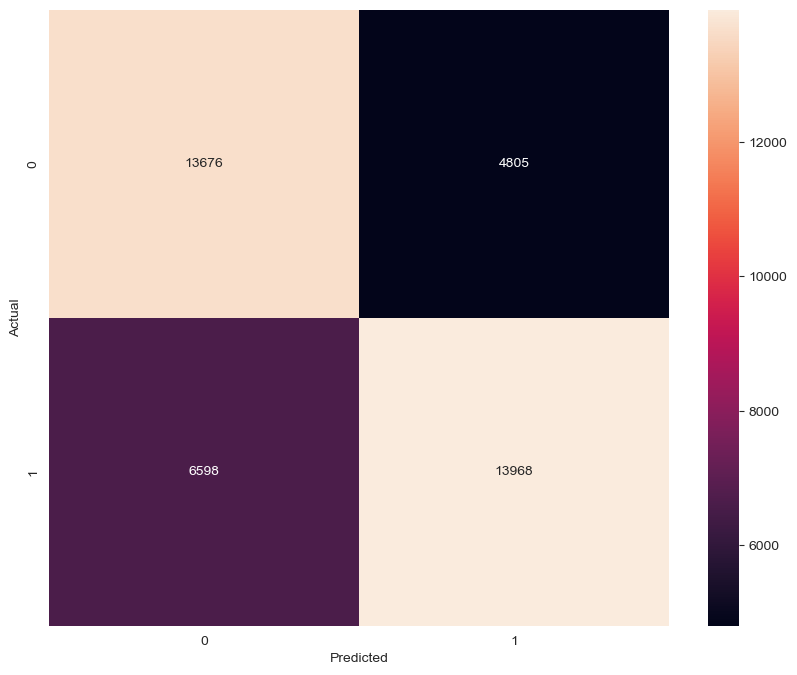

In [62]:
final_model = cbc_grid.best_estimator_
final_preds = final_model.predict(X_test)

cm = confusion_matrix(y_test, final_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Модель CatBoost хорошо показывает себя на тестовой выборке. Ошибается с положительными исходами чаще, чем с отрицательными.

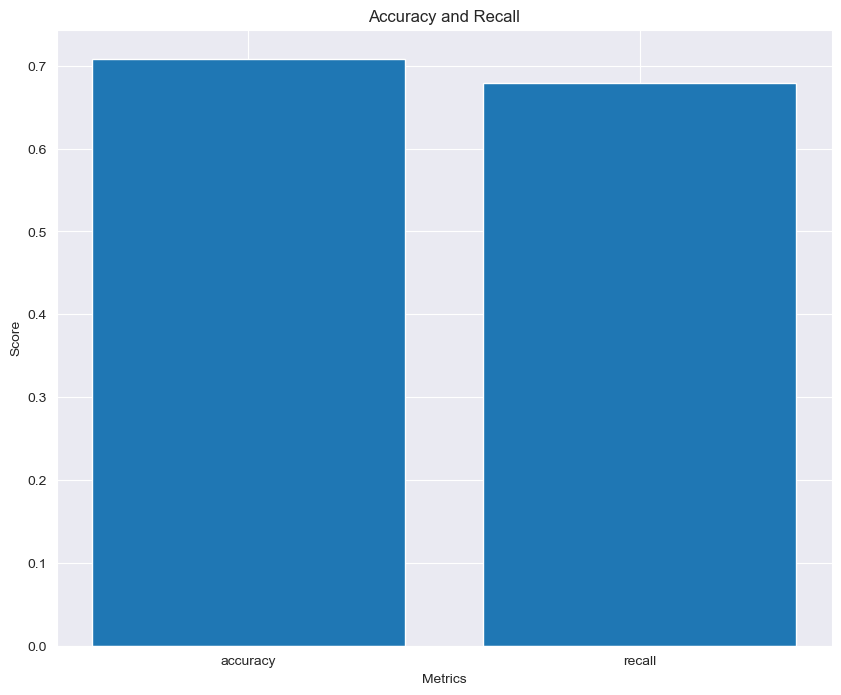

In [63]:
acc = accuracy_score(y_test, final_preds)
rec = recall_score(y_test, final_preds)

plt.figure(figsize=(10, 8))
plt.bar(['accuracy', 'recall'], [acc, rec])
plt.title('Accuracy and Recall')
plt.xlabel('Metrics')
plt.ylabel('Score')

plt.show()


In [64]:
analysis_X_train = col_trans.fit_transform(X_train)
new_columns = num_cols + cat_cols
analysis_X_train = pd.DataFrame(analysis_X_train, columns=new_columns)


In [65]:
explainer = shap.Explainer(final_model['model'])

shap_values_1 = explainer(analysis_X_train)
shap_values_2 = shap.TreeExplainer(final_model['model']).shap_values(analysis_X_train)


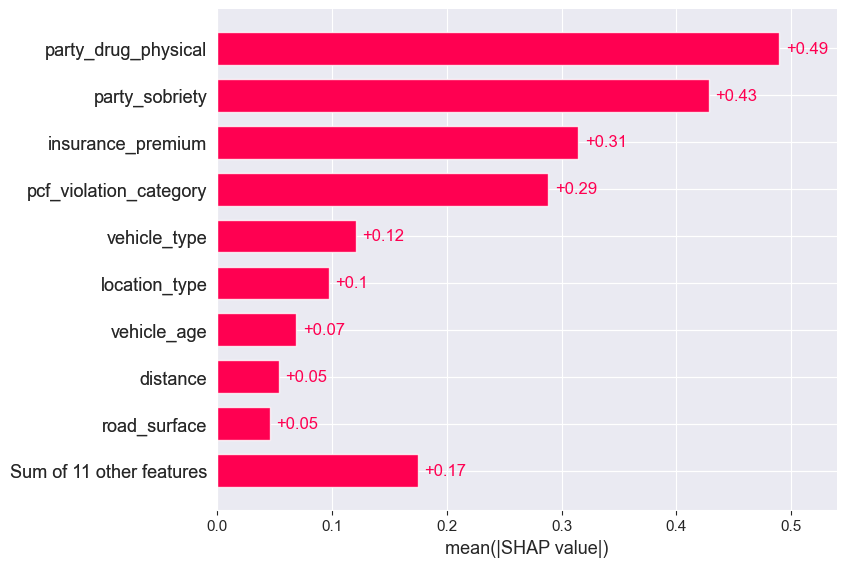

In [66]:
shap.plots.bar(shap_values_1)

Видим 4 основных фактора, которые влияют на исход аварии: party_drug_physical, party_sobriety, insurance_premium, pcf_violation_category.
1. Состояние участника: физическое или с учётом принятых лекарств
2. Трезвость участника
3. Сумма страховки (тыс. $)
4. Категория нарушения

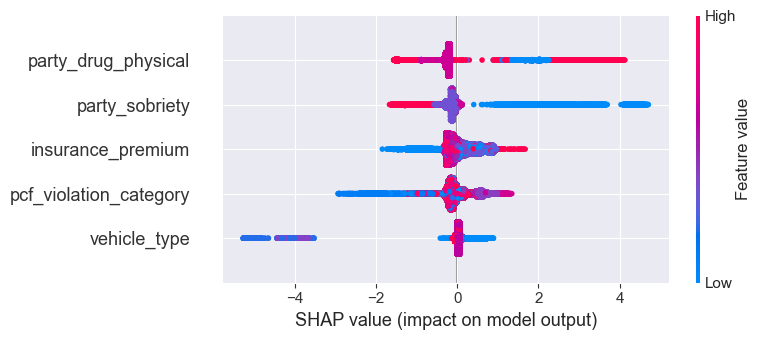

In [67]:
shap.summary_plot(shap_values_2, analysis_X_train, max_display=5, plot_size='auto')

### Выводы

Выявили, что основные факторы, влияющие на исход аварии, это влияние лекарственных средств на участника и трезвость участника. Также, важным фактором является сумма страховки и нарушения.

Предлагаю установить в автомобиль детектор алкоголя. Сделать обязательной проверку уровня алкоголя перед каждой поездкой. Для подтверждения, что тест проходит водитель, предусмотреть камеру, направленную на водительское место.

Также, можно установить ограничение скорости на транспортные средства, ввести штрафы за нарушения и предупреждения о нарушении.

## Выводы

In [68]:
f1 = 2 * (acc * rec) / (acc + rec)
print('Показатели лучшей модели на тестовой выборке:')
print('Accuracy:', acc)
print('Recall:', rec)
print('F1:', f1)

Показатели лучшей модели на тестовой выборке:
Accuracy: 0.7079673214331447
Recall: 0.6791792278517942
F1: 0.6932745483354056


Модель показывает неплохой результат, но его можно улучшить поработав более глубоко на предобработкой данных и подбором гиперпараметров.
Также, для улучшения показателей можно попробовать добавить следующие данные в датасет:
1. Данные о водителе
2. Данные о транспортном средстве
3. Исторические данные пользователя
4. Исторические данные транспортного средства
5. Количество перекрестков и других опасных мест на дороге